# Forex Pairs Trading Strategy Implementation

Implementation of the cointegration-based pairs trading strategy following the paper methodology.

## Paper Methodology
1. **Rolling Window Approach**: Test cointegration on training windows (63, 128, 257 days)
2. **Mean-Reversion Strategy**: Generate z-score signals if cointegration is found
3. **Parameter Optimization**: Test different combinations of:
   - Training windows: 63, 128, 257 days
   - Testing windows: 1, 5, 21, 63, 128 days  
   - Z-score thresholds: ±1, ±2, ±3
4. **Performance Evaluation**: Calculate risk-adjusted returns for all combinations

## Steps
1. Setup rolling window framework
2. Implement cointegration testing on training windows
3. Generate trading signals based on z-scores
4. Backtest all parameter combinations
5. Performance analysis and ranking

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from itertools import permutations
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuration
import sys
sys.path.append('../')
from config import (CURRENCY_PAIRS, TRAINING_WINDOWS, TESTING_WINDOWS, 
                   Z_SCORE_THRESHOLDS, SIGNIFICANCE_LEVEL, RISK_FREE_RATE, HOLDING_THRESHOLD)

# Display settings
plt.style.use('seaborn-v0_8')

In [2]:
# Load transformed forex data
forex_data = pd.read_csv('../data/forex_data.csv', index_col=0, parse_dates=True)
log_data = np.log(forex_data)

In [3]:
def cointegration_test(x_log, y_log, significance_level=SIGNIFICANCE_LEVEL):
    '''
    Return True if x and y are cointegrated, False otherwise.
    Also returns the cointegration coefficient (alpha) and the intercept.
    '''
    # Check individual stationarity
    x_adf = adfuller(x_log)[1]
    y_adf = adfuller(y_log)[1]
    if x_adf < significance_level or y_adf < significance_level:
        return False, 0, 0  # Return False if either series is not stationary
    # Perform cointegration test
    x_val = pd.DataFrame(x_log)
    y_val = y_log
    reg = LinearRegression(fit_intercept = True)
    reg.fit(x_val,y_val)
    alpha = reg.coef_[0]
    intercept = reg.intercept_
    prediction = reg.predict(x_val)
    res = y_val - prediction
    # Perform ADF test on residuals
    adfuller_result = adfuller(res)
    return (adfuller_result[1] < significance_level), alpha, intercept

In [4]:
def calculate_spread(x, y, alpha, intercept):
    '''
    Calculate the spread between two series x_log and y_log using the cointegration coefficient (alpha) and intercept.
    '''
    x = np.array(x)
    y = np.array(y)
    
    return y - (alpha * x + intercept)

In [5]:
def calculate_z_score(spread, mean_spread, std_spread):
    """
    Calculate the Z-score of a series.
    """
    return (spread - mean_spread) / std_spread

In [6]:
def generate_signal(z_score, z_score_threshold):
    """
    Generate trading signals based on the Z-score and threshold.
    """
    if z_score > z_score_threshold:
        return -1  # Short signal
    elif z_score < -z_score_threshold:
        return 1   # Long signal
    else:
        return 0   # No signal

In [7]:
def close_position(position, z_score, holding_period, holding_threshold=None):
    """
    Close the current position.
    """
    flag = False
    # Holding period logic
    if holding_threshold is not None:
        # Check if the holding period exceeds the threshold
        if holding_period >= holding_threshold:
            flag = True

    if position == 1 and (z_score >= 0 or flag):  # Long position
        return True
    
    elif position == -1 and (z_score <= 0 or flag):  # Short position
        return True
    
    return False  # Do not close the position

In [8]:
def backtest(pair, training_window, testing_window, z_score_threshold, holding_threshold):
    """
    Backtest the trading strategy for a given currency pair and windows.
    """
    x_name, y_name = pair
    x_log = log_data[x_name]
    y_log = log_data[y_name]

    # Split data into training and testing sets
    train_start = 0
    train_end = training_window
    test_start = training_window
    test_end = test_start + testing_window

    all_returns = []
    position = 0
    holding_period = 0

    while test_end <= len(x_log):
        # Extract training and testing data
        x_train = x_log[train_start:train_end]
        y_train = y_log[train_start:train_end]
        x_test = x_log[test_start:test_end]
        y_test = y_log[test_start:test_end]

        # Perform cointegration test
        is_cointegrated, alpha, intercept = cointegration_test(x_train, y_train)

        # Calculate spread and Z-score for training data
        spread_train = calculate_spread(x_train, y_train, alpha, intercept)
        mean_spread = spread_train.mean()
        std_spread = spread_train.std()

        
        if not is_cointegrated:
            all_returns.extend([0.0] * testing_window) # No returns if not cointegrated
        else:
            for t in range(testing_window):
                current_day = test_start + t

                # Skip first day
                if current_day <= 0:
                    all_returns.append(0.0)
                    continue

                x_t = x_log[current_day]
                y_t = y_log[current_day]
                x_t_1 = x_log[current_day - 1]
                y_t_1 = y_log[current_day - 1]

                # Calculate spread and Z-score
                spread_t_1 = calculate_spread(x_t_1, y_t_1, alpha, intercept) # Calculate spread for the previous day
                spread_t = calculate_spread(x_t, y_t, alpha, intercept) # Calculate spread for the current day
                z_score = calculate_z_score(spread_t_1, mean_spread, std_spread) # Calculate Z-score for the previous day

                # Generate trading signal
                signal = generate_signal(z_score, z_score_threshold)

                if position == 0:
                    if signal == 1:
                        position = 1
                        holding_period = 1
                    elif signal == -1:
                        position = -1
                        holding_period = 1
                    all_returns.append(0.0) # No return on the first day of the position

                elif position == 1:  # Long position
                    if close_position(position, z_score, holding_period, holding_threshold):
                        position = 0
                        print(f"Closing long position on {current_day} with z-score {z_score:.2f}")
                        holding_period = 0
                    else:
                        holding_period += 1
                    all_returns.append(spread_t - spread_t_1)  # Calculate return on closing position

                elif position == -1:  # Short position
                    if close_position(position, z_score, holding_period, holding_threshold):
                        position = 0
                        #print(f"Closing short position on {current_day} with z-score {z_score:.2f}")
                        holding_period = 0
                    else:
                        holding_period += 1
                    all_returns.append(spread_t_1 - spread_t)  # Calculate return on closing position

            


        # Shift the windows
        train_start += testing_window
        train_end += testing_window
        test_start += testing_window
        test_end += testing_window

    return all_returns


In [9]:
def calculate_metrics(returns):
    """
    Calculate risk-adjusted performance metrics from daily log returns.

    Parameters:
    - returns: array-like. Daily log returns of the strategy or asset.

    Returns:
    - dict: Dictionary containing the following metrics:
        - ann_ret: Annualised expected return (log).
        - ann_std_ret: Annualised standard deviation (volatility).
        - sharpe: Sharpe ratio (excess return over volatility).
        - sortino: Sortino ratio (excess return over downside deviation).
        - max_drawdown: Maximum drawdown (absolute value).
        - calmar: Calmar ratio (return over max drawdown).
    """
    ann_ret = np.mean(returns) * 252

    ann_std_ret = np.std(returns, ddof = 1) * np.sqrt(252)

    sharpe = (ann_ret - RISK_FREE_RATE) / ann_std_ret

    target = RISK_FREE_RATE / 252
    neg_ret = returns[returns < target]
    ann_std_down = np.sqrt(np.mean((neg_ret - target)**2)) * np.sqrt(252)
    sortino = (ann_ret - RISK_FREE_RATE) / ann_std_down

    cum_returns = np.exp(np.cumsum(returns))
    rolling_max = np.maximum.accumulate(cum_returns)
    drawdowns = (cum_returns - rolling_max) / rolling_max
    max_drawdown = abs(np.min(drawdowns))

    calmar = ann_ret / max_drawdown

    return {
        "ann_ret": ann_ret,
        "ann_std_ret": ann_std_ret,
        "sharpe": sharpe,
        "sortino": sortino,
        "max_drawdown": max_drawdown,
        "calmar": calmar
    }

In [10]:
def run_full_backtest(TRAINING_WINDOWS = TRAINING_WINDOWS, TESTING_WINDOWS = TESTING_WINDOWS, Z_SCORE_THRESHOLDS = Z_SCORE_THRESHOLDS, HOLDING_THRESHOLD = HOLDING_THRESHOLD):
    """
    Run full backtest for each combination.
    
    Parameters:
    - TRAINING_WINDOWS: List of possible training windows.
    - TESTING_WINDOWS: List of possible testing windows.
    - Z_SCORE_THRESHOLDS: List of possible z-thresholds.
    - HOLDING_THRESHOLD: Threshold for holding period.
    
    Returns:
    - Dataframe: Results of all the combinations
    """
    currency_pairs = list(permutations(log_data.columns, 2))
    results = []
    
    # Total iterations
    total_iterations = len(TRAINING_WINDOWS) * len(TESTING_WINDOWS) * len(Z_SCORE_THRESHOLDS) * len(currency_pairs)
    
    # Progress bar
    with tqdm(total = total_iterations, desc = "Running backtest") as pbar:
        for train_w in TRAINING_WINDOWS:
            for test_w in TESTING_WINDOWS:
                for z_thresh in Z_SCORE_THRESHOLDS:
                    for pair in currency_pairs:
                        # Update description
                        pbar.set_postfix({
                            'train': train_w, 'test': test_w, 
                            'z': z_thresh, 'pair': f"{pair[0]}-{pair[1]}"
                        })
                        
                        # Run backtest
                        returns = np.array(backtest(pair, train_w, test_w, z_thresh, HOLDING_THRESHOLD))

                        # Calculate metrics
                        metrics = calculate_metrics(returns)
                        
                        # Save results
                        results.append({
                            'pair': pair,
                            'train_window': train_w,
                            'test_window': test_w,
                            'z_threshold': z_thresh,
                            'returns': returns,
                            **metrics  # Unpack metrics dictionary
                        })
                        
                        # Update bar
                        pbar.update(1)
    
    return pd.DataFrame(results)

In [ ]:
# Run backtest
TRAINING_WINDOWS = [257]  # days
TESTING_WINDOWS = [21]  # days
Z_SCORE_THRESHOLDS = [3]  # standard deviations

results_df = run_full_backtest(TRAINING_WINDOWS, TESTING_WINDOWS, Z_SCORE_THRESHOLDS, HOLDING_THRESHOLD)

Running backtest:   0%|          | 0/42 [00:00<?, ?it/s]

Running backtest:   0%|          | 0/42 [00:00<?, ?it/s, train=257, test=21, z=3, pair=EURUSD-GBPUSD]

Closing long position on 1256 with z-score 0.45


Running backtest:   2%|▏         | 1/42 [00:01<01:05,  1.59s/it, train=257, test=21, z=3, pair=EURUSD-JPYUSD]

Closing long position on 4121 with z-score 0.20
Closing long position on 4256 with z-score 0.16


Running backtest:   5%|▍         | 2/42 [00:03<01:04,  1.61s/it, train=257, test=21, z=3, pair=EURUSD-CHFUSD]

Closing long position on 3947 with z-score 0.06
Closing long position on 265 with z-score 2.14
Closing long position on 1793 with z-score 0.00
Closing long position on 3166 with z-score 0.05


Running backtest:   7%|▋         | 3/42 [00:04<01:03,  1.63s/it, train=257, test=21, z=3, pair=EURUSD-CADUSD]

Closing long position on 4289 with z-score 0.82
Closing long position on 3050 with z-score 0.04


Running backtest:  10%|▉         | 4/42 [00:06<01:02,  1.65s/it, train=257, test=21, z=3, pair=EURUSD-AUDUSD]

Closing long position on 3659 with z-score 1.15


Running backtest:  14%|█▍        | 6/42 [00:10<01:01,  1.70s/it, train=257, test=21, z=3, pair=GBPUSD-EURUSD]

Closing long position on 2822 with z-score 0.62


Running backtest:  17%|█▋        | 7/42 [00:11<00:58,  1.67s/it, train=257, test=21, z=3, pair=GBPUSD-JPYUSD]

Closing long position on 3446 with z-score 0.39
Closing long position on 3951 with z-score 0.22


In [ ]:
def analyze_top_strategies(results_df, top_ns=[5, 10, 20, 30], plot=True):
    """
    Analizza e aggrega le metriche delle top-N strategie per Sharpe ratio.
    
    Parametri:
    - results_df: DataFrame con colonne ['returns', 'sharpe', ...]
    - top_ns: lista di N da considerare (default: [5, 10, 20, 30])
    - plot: se True, mostra il grafico delle cumulative returns
    
    Ritorna:
    - agg_df: DataFrame delle metriche aggregate per ogni N
    - cumulative_curves: dizionario N → curva cumulativa
    """
    aggregated_metrics = {}
    cumulative_curves = {}

    for n in top_ns:
        top_n = results_df.sort_values("sharpe", ascending=False).head(n)
        returns_matrix = np.vstack(top_n["returns"].values)
        agg_returns = np.mean(returns_matrix, axis=0)
        
        metrics = calculate_metrics(agg_returns)
        aggregated_metrics[n] = metrics
        cumulative_curves[n] = np.exp(np.cumsum(agg_returns))

    agg_df = pd.DataFrame(aggregated_metrics).T

    if plot:
        plt.figure(figsize=(10, 6))
        for n, curve in cumulative_curves.items():
            plt.plot(curve, label=f"Top {n}")
        plt.title("Standardized Cumulative Returns (Top-N Strategies)")
        plt.xlabel("Days")
        plt.ylabel("Cumulative Return")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return agg_df, cumulative_curves

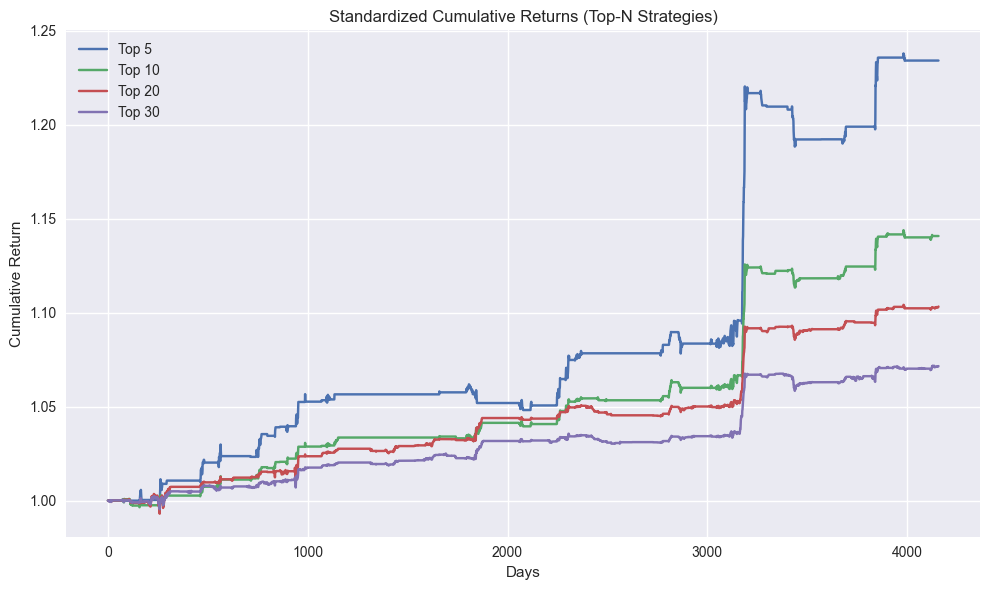

     ann_ret  ann_std_ret    sharpe   sortino  max_drawdown    calmar
5   0.012755     0.013630  0.935788  0.568325      0.026244  0.486002
10  0.007986     0.007129  1.120290  0.748518      0.010880  0.734011
20  0.005959     0.005587  1.066576  0.759012      0.010476  0.568771
30  0.004192     0.004371  0.959181  0.779606      0.008588  0.488166


In [ ]:
agg_metrics_df, curves = analyze_top_strategies(results_df)
print(agg_metrics_df)